## pattern generation

Running F=0.02, k=0.05 …
 → Writing GIF: gray_scott_F0.020_k0.050.gif
 → Plotting snapshot grid.


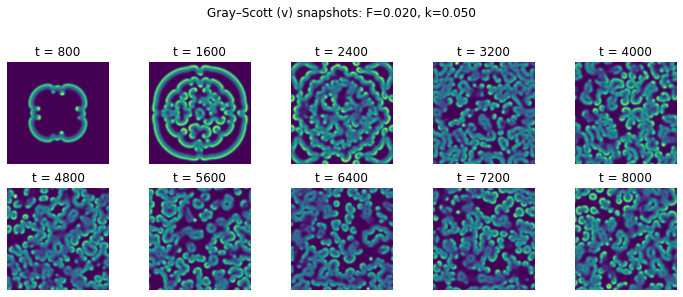

Running F=0.035, k=0.065 …
 → Writing GIF: gray_scott_F0.035_k0.065.gif
 → Plotting snapshot grid.


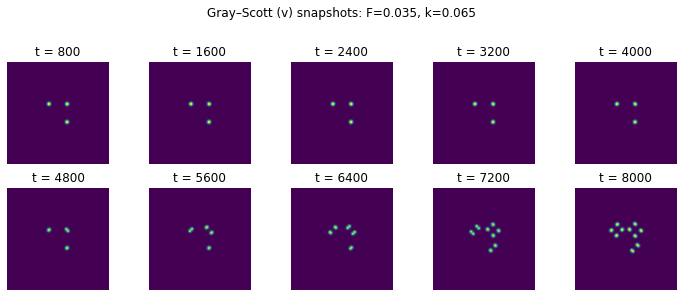

Running F=0.04, k=0.06 …
 → Writing GIF: gray_scott_F0.040_k0.060.gif
 → Plotting snapshot grid.


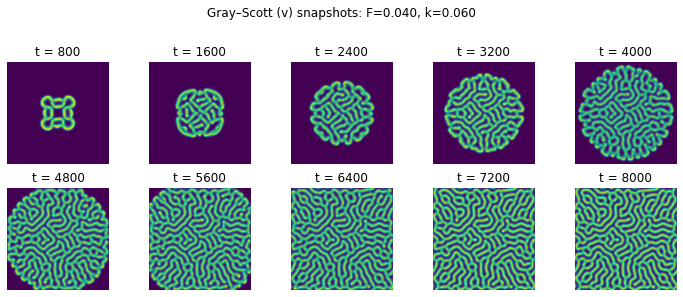

Running F=0.06, k=0.062 …
 → Writing GIF: gray_scott_F0.060_k0.062.gif
 → Plotting snapshot grid.


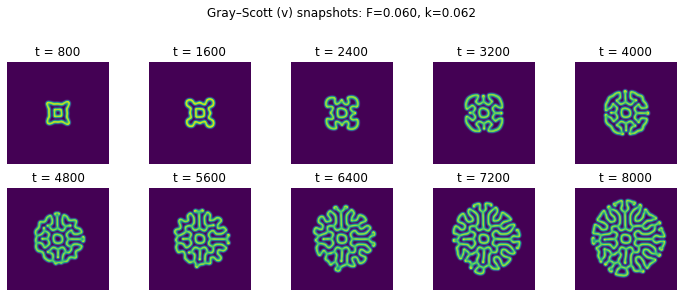

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import imageio

def gray_scott_imex_snapshots(N, L, Du, Dv, F, k,
                              dt, n_steps,
                              save_interval,
                              init_noise=0.02):
    """
    Run Gray–Scott IMEX and collect v snapshots every save_interval steps.
    Returns: (list of 2D arrays, list of times)
    """
    dx = L / N
    k_vals = 2 * np.pi * np.fft.fftfreq(N, d=dx)
    kx, ky = np.meshgrid(k_vals, k_vals)
    lap = -(kx**2 + ky**2)
    denom_u = 1 - dt * Du * lap
    denom_v = 1 - dt * Dv * lap

    u = np.ones((N, N))
    v = np.zeros((N, N))
    r = N//10
    c = N//2
    u[c-r:c+r, c-r:c+r] = 0.50 + init_noise*np.random.randn(2*r,2*r)
    v[c-r:c+r, c-r:c+r] = 0.25 + init_noise*np.random.randn(2*r,2*r)

    snapshots, times = [], []
    for step in range(1, n_steps+1):
        uvv = u * v * v
        Ru = -uvv + F*(1-u)
        Rv =  uvv - (F+k)*v
        u_star = u + dt * Ru
        v_star = v + dt * Rv

        u = np.real(np.fft.ifft2( np.fft.fft2(u_star) / denom_u ))
        v = np.real(np.fft.ifft2( np.fft.fft2(v_star) / denom_v ))

        if step % save_interval == 0:
            snapshots.append(v.copy())
            times.append(step * dt)

    return snapshots, times

def make_gif(snapshots, times, filename, cmap='viridis', fps=10):
    """Turn a list of 2D arrays into an animated GIF with time‐step annotation."""
    with imageio.get_writer(filename, mode='I', duration=1/fps) as writer:
        for v, t in zip(snapshots, times):
            fig, ax = plt.subplots(figsize=(4,4))
            ax.imshow(v, cmap=cmap, origin='lower')
            ax.axis('off')
            # annotate time
            ax.text(5, 5, f"t = {t:.0f}", color='white',
                    fontsize=12, weight='bold',
                    bbox=dict(facecolor='black', alpha=0.3, pad=2))
            fig.canvas.draw()
            img = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
            img = img.reshape(fig.canvas.get_width_height()[::-1] + (3,))
            writer.append_data(img)
            plt.close(fig)

def plot_snapshot_grid(snapshots, times, F, k, cmap='viridis'):
    """Show a grid of all snapshots, each titled by its time."""
    n = len(snapshots)
    cols, rows = 5,2
    # cols = int(np.ceil(np.sqrt(n)))
    # rows = int(np.ceil(n/cols))
    fig, axes = plt.subplots(rows, cols,
                             figsize=(cols*2, rows*2))
    axes = axes.flatten()
    for ax, (v, t) in zip(axes, zip(snapshots, times)):
        ax.imshow(v, cmap=cmap, origin='lower')
        ax.set_title(f"t = {t:.0f}")
        ax.axis('off')
    for ax in axes[n:]:
        ax.axis('off')
    fig.suptitle(f"Gray–Scott (v) snapshots: F={F:.3f}, k={k:.3f}", y=1.02)
    plt.tight_layout()
    plt.savefig(f"gray_scott_F{F:.3f}_k{k:.3f}_snapshots.png", 
                dpi=300, bbox_inches='tight')
    plt.show()

if __name__ == "__main__":
    # parameters to explore
    param_list = [
        (0.02, 0.050),
        (0.035, 0.065),
        (0.040, 0.060),
        (0.060, 0.062)
    ]

    # simulation settings
    N = 256
    L = 2.5
    Du, Dv = 2e-5, 1e-5
    dt = 1.0
    n_steps = 8000
    save_interval = 800   # frames at t=800,1600,…,8000

    for F, k in param_list:
        print(f"Running F={F}, k={k} …")
        snaps, times = gray_scott_imex_snapshots(
            N, L, Du, Dv, F, k,
            dt, n_steps,
            save_interval
        )

        gif_name = f"gray_scott_F{F:.3f}_k{k:.3f}.gif"
        print(f" → Writing GIF: {gif_name}")
        make_gif(snaps, times, gif_name)

        print(" → Plotting snapshot grid.")
        plot_snapshot_grid(snaps, times, F, k)